In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
import cv2
import numpy as np
from os import listdir as ld
from os.path import join as pj
import pandas as pd
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.nn.init as init
import torch.utils.data as data

# Loader
from IO.loader import load_path, load_images, load_annotations_path, load_annotations, get_anno_recs
# output XML
from IO.utils import output_formatter, write_output_xml
# Dataset
from dataset.detection.dataset import insects_dataset_from_voc_style_txt, collate_fn
# Predict
from model.refinedet.utils.predict import test_prediction
# Evaluate
from evaluation.detection.evaluate import evaluate
# Statistics
from evaluation.detection.statistics import compute_each_size_df, compute_all_size_df, compute_class_df, compute_error_df
# Visualize
from evaluation.detection.visualize import plot_df_distrib_size, plot_pr_curve, plot_df_distrib_class, plot_df_error, vis_detections

import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

# Test Config

In [3]:
class args:
    # experiment name
    experiment_name = "crop_b2_2_4_8_16_32_im512"
    # paths
    data_root = "/home/tanida/workspace/Insect_Phenology_Detector/data"
    test_image_root = "/home/tanida/workspace/Insect_Phenology_Detector/data/test_refined_images"
    model_root = pj("/home/tanida/workspace/Insect_Phenology_Detector/output_model/detection/RefineDet", experiment_name)
    figure_root = pj("/home/tanida/workspace/Insect_Phenology_Detector/figure/detection/RefineDet", experiment_name)
    test_anno_folders = ["annotations_4"]
    # training config
    input_size = 512 # choices=[320, 512, 1024]
    crop_num = (5, 5)
    tcb_layer_num = 5
    rm_last = True
    # test config
    save_fig = True
    save_df = True

# Model Config

In [4]:
if args.tcb_layer_num == 4 and args.rm_last == False:
    from model.refinedet.config import tcb_4_rm_false as insect_refinedet
elif args.tcb_layer_num == 4 and args.rm_last == True:
    from model.refinedet.config import tcb_4_rm_true as insect_refinedet
elif args.tcb_layer_num == 5 and args.rm_last == False:
    from model.refinedet.config import tcb_5_rm_false as insect_refinedet
elif args.tcb_layer_num == 5 and args.rm_last == True:
    from model.refinedet.config import tcb_5_rm_true as insect_refinedet
elif args.tcb_layer_num == 6 and args.rm_last == False:
    from model.refinedet.config import tcb_6_rm_false as insect_refinedet

# Set cuda

In [5]:
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    torch.set_default_tensor_type('torch.FloatTensor')

# Model

In [6]:
if args.rm_last == True:
    from model.refinedet.refinedet_rmlast import build_refinedet
else:
    from model.refinedet.refinedet import build_refinedet

### Make data

In [7]:
print('Loading dataset for test ...')
test_dataset = insects_dataset_from_voc_style_txt(args.test_image_root, args.input_size, args.crop_num, "RefineDet", training=False)
test_data_loader = data.DataLoader(test_dataset, 1, num_workers=1, shuffle=False, collate_fn=collate_fn)
print('Loading annotation for test...')
annos, imgs = load_path(args.data_root, "refined_images", args.test_anno_folders)
images = load_images(imgs)
annotations_path = load_annotations_path(annos, images)
anno = load_annotations(annotations_path)
imagenames, recs = get_anno_recs(anno)

Loading dataset for test ...
Loading annotation for test...


### Get model config

In [8]:
cfg = insect_refinedet[str(args.input_size)]

### Load model

In [9]:
print("Loading model for test ...")
model = build_refinedet('test', insect_refinedet, args.input_size, args.tcb_layer_num).cuda()
load_name = pj(args.model_root, 'RefineDet{}_{}.pth'.format(args.input_size, "30"))
model.load_state_dict(torch.load(load_name))

Loading model for test ...


In [10]:
model

RefineDet(
  (vgg): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (17): Conv2d

# --- result analysis ---

In [11]:
result = test_prediction(model, test_data_loader, args.crop_num, nms_thresh=0.3)
recall, precision, avg_precision, gt_dict = evaluate(result, recs)

In [12]:
avg_precision

0.8525065243875678

In [13]:
each_label_dic = {
    'Coleoptera': 0,
    'Diptera': 1,
    'Ephemeridae': 2,
    'Ephemeroptera': 3,
    'Hemiptera': 4,
    'Lepidoptera': 5,
    'Plecoptera': 6,
    'Trichoptera': 7,
    'small insect': 8,
    'medium insect': 9
}

### --- visualize accuracy distribution of size ---

In [14]:
each_df = compute_each_size_df(gt_dict)
if args.save_df is True:
    each_df.to_csv(pj(args.figure_root, "each_size_df.csv"))
each_df

,Accuracy,Insect_size
0,1,1541
1,1,24650
2,1,20706
3,1,625
4,1,702
...,...,...
618,1,6072
619,1,1404
620,1,1134
621,1,920


In [15]:
all_df = compute_all_size_df(each_df)
if args.save_df is True:
    all_df.to_csv(pj(args.figure_root, "all_size_df.csv"))
all_df

,Accuracy,Insect_size,order
order,,,
7.0,0.933333,224.800000,7.0
8.0,1.000000,394.436464,8.0
9.0,0.994709,726.137566,9.0
10.0,0.988095,1420.392857,10.0
11.0,0.980000,2870.260000,11.0
12.0,0.973684,6288.526316,12.0
13.0,0.957447,11189.978723,13.0
14.0,1.000000,22611.437500,14.0
15.0,1.000000,37326.666667,15.0


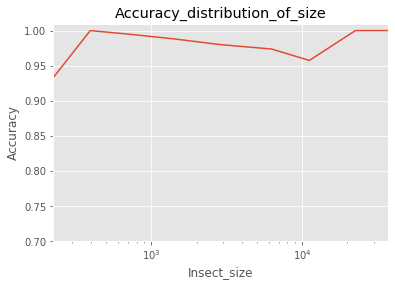

In [16]:
plot_df_distrib_size(all_df, args.figure_root, save=args.save_fig)

In [17]:
df = pd.DataFrame({"precision": precision, "recall": recall})
if args.save_df is True:
    df.to_csv(pj(args.figure_root, "pr_curve_df.csv"))
df

,precision,recall
0,0.001605,1.000000
1,0.003210,1.000000
2,0.004815,1.000000
3,0.006421,1.000000
4,0.008026,1.000000
...,...,...
14009,0.988764,0.043969
14010,0.988764,0.043965
14011,0.988764,0.043962
14012,0.988764,0.043959


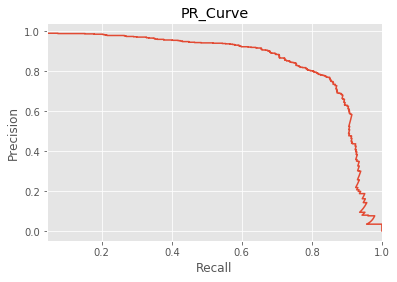

In [18]:
plot_pr_curve(df, args.figure_root, save=args.save_fig)

### --- visualize accuracy distribution of class ---

In [19]:
df = compute_class_df(each_label_dic, gt_dict)
if args.save_df is True:
    df.to_csv(pj(args.figure_root, "each_class_df.csv"))
df

,Name,Precision_per_class
0,Coleoptera,1.000000
1,Diptera,0.963636
2,Ephemeridae,0.923077
3,Ephemeroptera,1.000000
4,Lepidoptera,1.000000
5,Plecoptera,1.000000
6,Trichoptera,0.961538
7,small insect,0.991957
8,medium insect,1.000000


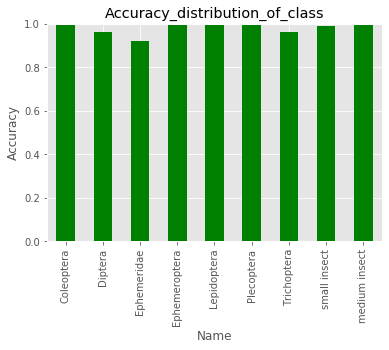

In [20]:
plot_df_distrib_class(df, args.figure_root, save=args.save_fig, color="green")

### --- visualize error count per class ---

In [22]:
df = compute_error_df(each_label_dic, gt_dict)
if args.save_df is True:
    df.to_csv(pj(args.figure_root, "each_class_error_df.csv"))
df

,Name,Error_count
0,Diptera,2.0
1,Ephemeridae,1.0
2,Trichoptera,1.0
3,small insect,3.0


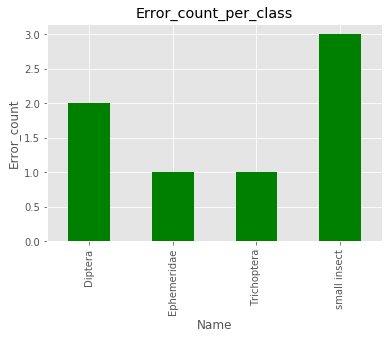

In [23]:
plot_df_error(df, args.figure_root, save=args.save_fig, color="green")

### --- output labelImg XML ---

In [24]:
output = output_formatter(result, thresh=0.3)
write_output_xml(output, "/home/tanida/workspace/Insect_Phenology_Detector/output_xml/refinedet_crop_b2_2_4_8_16_32_im512")

folder is already exist. check and move folder.


### --- compare ground truth and output ---

In [25]:
im_index = 0
if os.path.exists(args.figure_root) is False:
    os.makedirs(args.figure_root)

In [26]:
gt   = np.asarray(list(map(lambda x:x["bbox"]+[1], recs[imagenames[im_index]])))
gazo = np.asarray(Image.open(pj("/home/tanida/workspace/Insect_Phenology_Detector/data/refined_images", imagenames[im_index]+".png")))
x = vis_detections(gazo, result[imagenames[im_index]], color_name="blue")
x = vis_detections(x, gt, color_name="red")
x = Image.fromarray(x)
x.save(pj(args.figure_root, imagenames[im_index]+".png"))
print(imagenames[im_index])
im_index += 1
#x

20180615-0348


### --- compare different iou ---

In [27]:
for thresh in [.3, .5, .7]:
    recall, precision, avg_precision, gt_dict = evaluate(result, recs, ovthresh=thresh)
    print("thresh == {0}, ap == {1}".format(thresh, avg_precision))

thresh == 0.3, ap == 0.8525065243875678
thresh == 0.5, ap == 0.5692649810868082
thresh == 0.7, ap == 0.140863643334436
